Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Davide Belli, Gabriele Cesa"

---

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Deep Q-Network (DQN) (10 (+ 2 bonus) points)

In [3]:
import gym
env = gym.envs.make("CartPole-v0")

In [4]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [5]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

Can you think of a way in which we can still use a tabular approach? Why would this work and can you think of an example problem where this would not work?

# Check Me!

We can use binning (aggregation) to approximate the infinite number of possible state with a discrete number of state representing interval over the feature's domains. 

This approach would not work for problems in which the optimal (or sufficient) action for every state is unique and can be expressed as a function of the state feature values. In this case an approximation of the infinite states using binning approach would result in a wrong action for that state

### 1.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [6]:
import torch.nn.functional as F

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        return self.l2(F.relu(self.l1(x)))

In [7]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

### 1.2 Experience Replay

What could be a problem with doing gradient updates on a sequence of state, action pairs $((s_t, a_t), (s_{t+1}, a_{t+1}) ...)$ observed while interacting with the environment? How will using *experience replay* help to overcome this (potential problem)?

# Check me

The problem is that successive updates in the original Q-learning approach are corralated to each other. This increases the variance in the learning and can cause instabilities. 
Experience replay can be used to solve this problem by saving an history of experiences from interacting with the environment and then learning a model by sampling experiences from this history, in order to avoid sequential updates (from Sutton and Barto, pp. 440-441).

Now implement the `push` function that adds a transition to the replay buffer, and the sample function that returns a batch of samples. It should keep at most the maximum number of transitions. Also implement the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`).

In [8]:
import random
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self) < self.capacity:
            self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))


[(array([0.01931464, 0.02393047, 0.03653237, 0.00586133]), 0, 1.0, array([ 0.01979325, -0.17169585,  0.0366496 ,  0.30984314]), False)]


### 1.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [10]:
def get_epsilon(it):
    # YOUR CODE HERE
    raise NotImplementedError()

In [11]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])


NotImplementedError: 

Now write a function that takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon (which we will pass later). Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Unlike numpy, PyTorch has no argmax function, but Google is your friend... Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [12]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()

In [13]:
s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)


NotImplementedError: 

### 1.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [14]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    raise NotImplementedError()
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    raise NotImplementedError()

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [15]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(model.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(model, memory, optimizer, batch_size, discount_factor)

print (loss)


NotImplementedError: 

### 1.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [16]:
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        # YOUR CODE HERE
        raise NotImplementedError()
    return episode_durations

In [17]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

NotImplementedError: 

In [18]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')


NameError: name 'episode_durations' is not defined

### 1.6 Semi-gradient vs. true gradient (bonus)

Note that by using automatic differentiation in PyTorch, it is (relatively) easy to implement the true gradient method. Hint: PyTorch may complain about computing gradients for the target in [smooth_l1_loss](https://pytorch.org/docs/stable/nn.html?highlight=smooth_l1_loss#torch.nn.functional.smooth_l1_loss). How can you circumvent this problem? Implement the `train_true_gradient` method below.

In [19]:
def train_true_gradient(model, memory, optimizer, batch_size, discount_factor):
    
    # YOUR CODE HERE
    raise NotImplementedError()

random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations_true_gradient = run_episodes(
    train_true_gradient, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

plt.plot(smooth(episode_durations, 10))
plt.plot(smooth(episode_durations_true_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Semi-gradient', 'True gradient'])

NotImplementedError: 

Which algorithm performs better? Is this what you would expect? Can you explain this?

Note: you may want to play around with the number of episodes to answer this question, but please reset it to 100 before handing in the notebook.

YOUR ANSWER HERE

---

## 2. Policy Gradient (8 points)

So we have spent a lot of time working on *value based* methods. We will now switch to *policy based* methods, i.e. learn a policy directly rather than learn a value function from which the policy follows. Mention two advantages of using a policy based method.

Some advantages of using policy based methods are:
- easier to include prior knowledge
- we directly optimize the quantities of interest
- easier to ensure smooth changes of the policies

### 2.1 Policy Network

In order to do so, we will implement a Policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) log-probability of selecting that action. *Use the (log-)softmax activation function.*

In [20]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.nn.functional.log_softmax(x)
        return x

In [21]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = PolicyNetwork(num_hidden)

x = torch.rand(10, 4)

log_p = model(x)

# Does the outcome make sense?
print(log_p.exp())


/home/gabriele/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<ExpBackward>)


### 2.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember from lab 1 that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

To help you, we already implemented a few functions that you can (but do not have to) use.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.
* Importantly, you should **normalize the returns** (not the rewards!, e.g. subtract mean and divide by standard deviation within the episode) before computing the loss, or your estimator will have very high variance.

In [28]:
def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    
    log_p = model(torch.FloatTensor(state))
    
    action = torch.multinomial(torch.exp(log_p), 1).item()
    
    return action, log_p[action]

def run_episode(env, model):
    
    episode = []
    
    s = env.reset()
    done = False
    while not done:
        a, log_p = select_action(model, s)
        s_next, r, done, _ = env.step(a)
        
        episode.append((s, a, log_p, s_next, r))
        s = s_next
    
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    returns = []
    log_ps = []
    G = 0
    for _, _, log_p, _, r in reversed(episode):
        G = r + discount_factor * G
        returns.append(G)
        log_ps.append(log_p)
        
    log_ps = torch.stack(log_ps)
    returns = torch.FloatTensor(returns)
    returns -= returns.mean()
    returns /= returns.std()
    
    loss = -1 * torch.sum(log_ps * returns)
    return loss

def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        
        optimizer.zero_grad()
        
        episode = run_episode(env, model)
        loss = compute_reinforce_loss(episode, discount_factor)
        
        loss.backward()
        optimizer.step()
                           
        if i % 20 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
        episode_durations.append(len(episode))
        
    return episode_durations

/home/gabriele/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


 Episode 0 finished after 19 steps
 Episode 20 finished after 27 steps
 Episode 40 finished after 200 steps
 Episode 60 finished after 57 steps
 Episode 80 finished after 41 steps
 Episode 100 finished after 200 steps
 Episode 120 finished after 200 steps
 Episode 140 finished after 200 steps
 Episode 160 finished after 200 steps
 Episode 180 finished after 105 steps
 Episode 200 finished after 107 steps
 Episode 220 finished after 122 steps
 Episode 240 finished after 134 steps
 Episode 260 finished after 200 steps
 Episode 280 finished after 200 steps
 Episode 300 finished after 200 steps
 Episode 320 finished after 200 steps
 Episode 340 finished after 98 steps
 Episode 360 finished after 53 steps
 Episode 380 finished after 137 steps
 Episode 400 finished after 200 steps
 Episode 420 finished after 200 steps
 Episode 440 finished after 200 steps
 Episode 460 finished after 200 steps
 Episode 480 finished after 127 steps


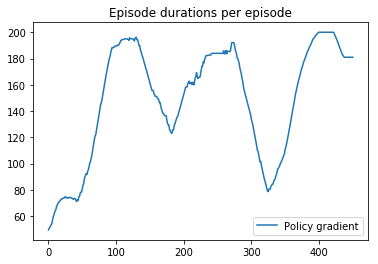

In [29]:
# Feel free to play around with the parameters!
num_episodes = 500
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = PolicyNetwork(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    model, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

---
## Actor-Critic (7 points)

We will now implement the basic Actor-Critic algorithm, which means that instead of using Monte Carlo returns, we will bootstrap (1-step) returns using a critic (state-value function), so $G_t = R_t + \gamma V(s_{t+1})$. What happens at the end of the episode? Hint: you may find it useful to have a look at the `train` method for DQN.

* Note that we now have to train an actor (policy) and a critic (value network).
* We will do this using a single optimizer, which means that we have to sum the loss for the actor and the critic into a single loss term. 
* For the critic, use the `smooth_l1_loss` like with DQN.
* For the actor, the loss should be the REINFORCE loss, but with two differences:
    - Instead of the Monte Carlo return $G_t$, use the one step return $G_{t:t+1}$ where the critic is used to bootstrap the value of $s_{t+1}$.
    - Instead of normalizing the returns (which can be viewed as using the average as baseline and then scaling), we will use the estimated value $V(s_t)$ as baseline.
* **Important**: note that you cannot use `with torch.no_grad():` to compute the critic value (for the current state) since you need gradients to train the critic! However, when using the value to compute the actor loss, you do not want to get gradients of the critic parameters w.r.t. the actor loss (e.g. your target and baseline must be constant)! Therefore, use `v.detach()` on the output of the critic when it is used in the loss term for the actor, this will make sure the value(s) are treated as a constant and no gradients will be backpropagated.

In [ ]:
class ValueNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
    

def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    # YOUR CODE HERE
    raise NotImplementedError()
    # action and log_p should be a 1 dimensional vector
    n = len(state)
    assert action.size() == (n, )
    assert log_p.size() == (n, )
    return action, log_p

def train_actor_critic(actor, critic, optimizer, log_ps, state, reward, next_state, done, discount_factor):
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # The loss is composed of the value_loss (for the critic) and the actor_loss
    loss = value_loss + actor_loss

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), value_loss.item(), actor_loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes_actor_critic(actor, critic, envs, max_episodes, max_steps, discount_factor, actor_learn_rate, critic_learn_rate):
    
    # We can use a single optimizer for both the actor and the critic, even with separate learn rates
    optimizer = optim.Adam([
        {'params': actor.parameters(), 'lr': actor_learn_rate},
        {'params': critic.parameters(), 'lr': critic_learn_rate}
    ])
    
    episode_durations = []
    state = torch.tensor([env.reset() for env in envs], dtype=torch.float)
    current_episode_lengths = torch.zeros(len(envs), dtype=torch.int64)
    step_losses = []  # Keep track of losses for plotting
    for i in range(max_steps):
        
        if i % 100 == 0:
            print(f"Step {i}, finished {len(episode_durations)} / {num_episodes} episodes, average episode duration of last 100 episodes: {np.mean(episode_durations[-100:])}")
        
        action, log_ps = select_action(actor, state)
        next_state, reward, done, _ = zip(*[env.step(a.item()) for env, a in zip(envs, action)])
        
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        done = torch.tensor(done, dtype=torch.uint8)  # Boolean
        current_episode_lengths += 1
        
        losses = train_actor_critic(actor, critic, optimizer, log_ps, state, reward, next_state, done, discount_factor)
        
        step_losses.append(losses)
        
        # Reset envs that are done
        next_state = torch.tensor([
            env.reset() if d else s.tolist()
            for env, s, d in zip(envs, next_state, done)
        ], dtype=torch.float)
        
        episode_durations.extend(current_episode_lengths[done])
        current_episode_lengths[done] = 0  # PyTorch can also work in place
        
        state = next_state
        
        # Check if we have finished sufficiently many episodes
        if len(episode_durations) >= max_episodes:
            break
        
    return episode_durations[:max_episodes], step_losses  # In case we want exactly num_episodes returned


num_envs = 16
max_steps = 10000
max_episodes = 10000
discount_factor = 0.8
lr_actor = 1e-3
lr_critic = 1e-3
seed = 42

actor = PolicyNetwork(num_hidden)
critic = ValueNetwork(num_hidden)

envs = [gym.envs.make("CartPole-v0") for i in range(num_envs)]

for i, env in enumerate(envs):
    env.seed(seed + i)
torch.manual_seed(seed)

episode_durations, step_losses = run_episodes_actor_critic(actor, critic, envs, max_episodes, max_steps, discount_factor, lr_actor, lr_critic)

In [ ]:
plt.plot(smooth(episode_durations, 100))
plt.title('Episode durations')
plt.show()
loss, v_loss, a_loss = zip(*step_losses)

plt.plot(smooth(v_loss, 100))
plt.title('Value loss')
plt.show()
plt.plot(smooth(a_loss, 100))
plt.title('Actor loss')
plt.show()

What is the difficulty of training AC algorithms? What could you try to do to overcome these difficulties? Hint: look at some online implementations.

YOUR ANSWER HERE

## Deep Reinforcement Learning (5 bonus points)
Note that so far we used the state variables as input. However, the true power of Deep Learning is that we can directly learn from raw inputs, e.g. we can learn to balance the cart pole *by just looking at the screen*. This probably means that you need a deep(er) (convolutional) network, as well as tweaking some parameters, running for more iterations (perhaps on GPU) and do other tricks to stabilize learning. Can you get this to work? This will earn you bonus points!

Hints:
* You may want to use [Google Colab](https://colab.research.google.com/) such that you can benefit from GPU acceleration.
* Even if you don't use Colab, save the weights of your final model and load it in the code here (see example below). Hand in the model file with the .ipynb in a .zip. We likely won't be able to run your training code during grading!
* To run the code below, you need to install `torchvision`, for this uncomment the two lines in the cell below or run the command in a terminal. Note: you may need to restart the terminal after installing.
* Preprocessing is already done for you, and the observation is the difference between two consequtive frames such that the model can 'see' (angular) speed from a single image. Now do you see why we (sometimes) use the word observation (and not state)?

In [ ]:
# %%bash
# conda install torchvision -c pytorch

In [ ]:
import torchvision.transforms as T
from PIL import Image


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class CartPoleRawEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self._env = gym.make('CartPole-v0', *args, **kwargs)  #.unwrapped
        self.action_space = self._env.action_space
        screen_height, screen_width = 40, 80  # TODO
        self.observation_space = gym.spaces.Box(
            low=0, high=255, 
            shape=(screen_height, screen_width, 3), dtype=np.uint8)
    
    def seed(self, seed=None):
        return self._env.seed(seed)
    
    def reset(self):
        s = self._env.reset()
        self.prev_screen = self.screen = self.get_screen()
        return self._get_observation()
    
    def step(self, action):
        s, r, done, info = self._env.step(action)
        self.prev_screen = self.screen
        self.screen = self.get_screen()
        return self._get_observation(), r, done, info
    
    def _get_observation(self):
        return self.screen - self.prev_screen
    
    def _get_cart_location(self, screen_width):
        _env = self._env.unwrapped
        world_width = _env.x_threshold * 2
        scale = screen_width / world_width
        return int(_env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen(self):
        screen = self._env.unwrapped.render(mode='rgb_array').transpose(
            (2, 0, 1))  # transpose into torch order (CHW)
        # Strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, screen_height * 4 // 10:screen_height * 8 // 10]
        view_width = screen_height * 8 // 10
        cart_location = self._get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescare, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        #return screen.unsqueeze(0).to(device)
        return resize(screen).unsqueeze(0)
    
    def close(self):
        return self._env.close()

raw_env = CartPoleRawEnv()
s = raw_env.reset()

# 
s, r, done, _ = raw_env.step(env.action_space.sample())

raw_env.reset()
plt.figure()
plt.imshow(raw_env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Observations are (-1, 1) while we need to plot (0, 1) so show (rgb + 1) / 2
plt.figure()
plt.imshow((s.cpu().squeeze(0).permute(1, 2, 0).numpy() + 1) / 2,
           interpolation='none')
plt.title('Example observation')
plt.show()
raw_env.close()

In [ ]:
# Maybe you should make it a bit deeper?
class DeepPolicy(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(40 * 80 * 3, 2)

    def forward(self, x):
        # Flatten
        return F.log_softmax(self.l1(x.view(x.size(0), -1)), -1)
    
policy = DeepPolicy()
filename = 'weights.pt'

if os.path.isfile(filename):
    print(f"Loading weights from {filename}")
    weights = torch.load(filename)
    
    policy.load_state_dict(weights['policy'])
    
else:
    # Train
    
    ### TODO some training here, maybe? Or run this on a different machine?
    torch.manual_seed(42)
    
    print(f"Saving weights to {filename}")
    torch.save({
        # You can add more here if you need, e.g. critic
        'policy': policy.state_dict()  # Always save weights rather than objects
    },
    filename)
    
def bonus_get_action(x):
    return policy(x).exp().multinomial(1)[:, 0]

In [ ]:
seed = 42
episode_durations = []
for i in range(20):  # Not too many since it may take forever to render
    test_env = CartPoleRawEnv()
    test_env.seed(seed + i)
    state = test_env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        with torch.no_grad():
            action = bonus_get_action(state).item()
        state, reward, done, _ = test_env.step(action)
    episode_durations.append(steps)
    test_env.close()
    
plt.plot(smooth(episode_durations, 100))
plt.title('Episode durations')
plt.show()
